# Cluster DE isoform only

In [1]:
!mkdir plots tables

mkdir: cannot create directory ‘plots’: File exists
mkdir: cannot create directory ‘tables’: File exists


In [2]:
import sys

colab = "google.colab" in sys.modules

if colab:
    # download files
    !git clone https://github.com/pachterlab/BYVSTZP_2020.git
    !wget -q -c --show-progress --progress=bar:force -O gene.h5ad.gz https://caltech.box.com/shared/static/2qut50hmb5r2zynd0dkihlj0qpwi6576.gz 2>&1
    !wget -q -c --show-progress --progress=bar:force -O isoform.h5ad.gz https://caltech.box.com/shared/static/7n6n9fvs2737shskqaiamw0dob9rbwva.gz 2>&1
    !gunzip *.gz

    !pip install --quiet anndata

In [3]:
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
from scipy.stats import ks_2samp, ttest_ind
import ast
from scipy.sparse import csr_matrix
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('BYVSTZP_2020/dexpress')
from dexpress import dexpress, utils, plot


fsize=20

plt.rcParams.update({'font.size': fsize})
%config InlineBackend.figure_format = 'retina'

In [4]:
cluster_cmap = {
"Astro": (0.38823529411764707, 0.4745098039215686,  0.2235294117647059 ),  # 637939,
"Endo" : (0.5490196078431373,  0.6352941176470588,  0.3215686274509804 ),  # 8ca252,
"SMC"  : (0.7098039215686275,  0.8117647058823529,  0.4196078431372549 ),  # b5cf6b,
"VLMC" : (0.807843137254902,   0.8588235294117647,  0.611764705882353  ),  # cedb9c,
"Low Quality" : (0,0,0),
"L2/3 IT" : (0.9921568627450981,  0.6823529411764706,  0.4196078431372549  ),  # fdae6b
"L5 PT" : (0.9921568627450981,  0.8156862745098039,  0.6352941176470588  ),  # fdd0a2
"L5 IT" : (0.5176470588235295,  0.23529411764705882, 0.2235294117647059 ),  # 843c39
"L5/6 NP": "#D43F3A",
"L6 CT" : (0.8392156862745098,  0.3803921568627451,  0.4196078431372549 ),  # d6616b
"L6 IT" : (0.9058823529411765,  0.5882352941176471,  0.611764705882353  ),  # e7969c
"L6b" : (1.0,                 0.4980392156862745,  0.054901960784313725),  # ff7f0e
"L6 IT Car3" : (1.0,                 0.7333333333333333,  0.47058823529411764 ),  # ffbb78
"Lamp5" : (0.19215686274509805, 0.5098039215686274,  0.7411764705882353  ),  # 3182bd # blues
"Sncg" : (0.4196078431372549,  0.6823529411764706,  0.8392156862745098  ),  # 6baed6
"Vip" : (0.6196078431372549,  0.792156862745098,   0.8823529411764706  ),  # 9ecae1
"Sst" : (0.7764705882352941,  0.8588235294117647,  0.9372549019607843  ),  # c6dbef
"Pvalb":(0.7372549019607844,  0.7411764705882353,  0.8627450980392157  ),  # bcbddc
}

In [5]:
gene = anndata.read_h5ad("gene.h5ad")
isoform = anndata.read_h5ad("isoform.h5ad")

In [6]:
isoform = isoform[:,isoform.var.sort_values("gene_id").index]
gene = gene[:,gene.var.sort_values("gene_id").index]

In [7]:
isoform = isoform[isoform.obs.eval("subclass_label != 'L5 IT'").values]
gene = gene[gene.obs.eval("subclass_label != 'L5 IT'").values]

09-Jul-21 16:47:36 - Note: NumExpr detected 48 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
09-Jul-21 16:47:36 - NumExpr defaulting to 8 threads.


In [8]:
print(isoform.shape)
print(gene.shape)

(4599, 69172)
(4599, 19190)


In [9]:
gene = gene[gene.obs.subclass_label=="L6 CT"]
isoform = isoform[isoform.obs.subclass_label=="L6 CT"]

In [10]:
%%time
mat           = gene.layers["log1p"].todense()
components    = gene.obs.cell_id.values
features      = gene.var.gene_name.values
assignments   = gene.obs.cluster_label.values

unique = np.unique(assignments)
nan_cutoff = 0.9 # of elements in cluster
corr_method = "bonferroni"


p_raw, stat, es, nfeat = dexpress.dexpress(mat, components, features, assignments, nan_cutoff=nan_cutoff)
p_raw = p_raw/2
p_corr = utils.correct_pval(p_raw, nfeat, corr_method)

s = stat

markers_gene = dexpress.make_table(assignments, features, p_raw, p_corr, es)

# convert the 0 pvalues to the smallest possible float
markers_gene["p_corr"][markers_gene.eval("p_corr == 0").values] = sys.float_info.min
markers_gene = markers_gene.query("es > 0")

09-Jul-21 16:47:37 - 1 of 5 assignments: L6 CT Gpr139
09-Jul-21 16:47:37 - 2 of 5 assignments: L6 CT Grp_1
09-Jul-21 16:47:37 - 3 of 5 assignments: L6 CT Grp_2
09-Jul-21 16:47:37 - 4 of 5 assignments: L6 CT Nxph2_1
09-Jul-21 16:47:37 - 5 of 5 assignments: L6 CT Nxph2_2


CPU times: user 585 ms, sys: 331 ms, total: 916 ms
Wall time: 911 ms


In [11]:
%%time
mat         = isoform.layers["log1p"].todense() # expects dense matrix
components  = isoform.obs.cell_id.values
features    = isoform.var.transcript_name.values
assignments = isoform.obs.cluster_label.values

unique = np.unique(assignments)
nan_cutoff = 0.9 # of elements in cluster
corr_method = "bonferroni"


p_raw, stat, es, nfeat = dexpress.dexpress(mat, components, features, assignments, nan_cutoff=nan_cutoff)
p_raw = p_raw/2
p_corr = dexpress.correct_pval(p_raw, nfeat, corr_method)

s = stat

markers_isoform = dexpress.make_table(assignments, features, p_raw, p_corr, es)

# convert the 0 pvalues to the smallest possible float
markers_isoform["p_corr"][markers_isoform.eval("p_corr == 0").values] = sys.float_info.min
markers_isoform = markers_isoform.query("es > 0")

09-Jul-21 16:47:38 - 1 of 5 assignments: L6 CT Gpr139
09-Jul-21 16:47:38 - 2 of 5 assignments: L6 CT Grp_1
09-Jul-21 16:47:39 - 3 of 5 assignments: L6 CT Grp_2
09-Jul-21 16:47:39 - 4 of 5 assignments: L6 CT Nxph2_1
09-Jul-21 16:47:39 - 5 of 5 assignments: L6 CT Nxph2_2


CPU times: user 1.34 s, sys: 1.01 s, total: 2.35 s
Wall time: 2.34 s


# Look at isoform markers

In [12]:
alpha = 0.01
markers_isoform = markers_isoform.query(f"p_corr < {alpha}")
markers_isoform.sort_values("es").tail()

,index,name,p_raw,p_corr,es
59750,L6 CT Gpr139,Nnat-205_ENSMUST00000153739,0.0,0.000001,4.222461
332278,L6 CT Nxph2_2,Glipr1-201_ENSMUST00000074805,0.0,0.001423,4.471843
5413,L6 CT Gpr139,Acaa1b-201_ENSMUST00000010795,0.0,0.000000,4.838846
285335,L6 CT Nxph2_2,Nts-201_ENSMUST00000020040,0.0,0.000008,5.779428
18275,L6 CT Gpr139,Gal-201_ENSMUST00000025842,0.0,0.000000,6.622659


In [13]:
markers_isoform.shape

(551, 5)

In [14]:
specific_cluster = "L6 CT Gpr139"
specific_isoform = "Gal-201_ENSMUST00000025842"
specific_gene = "".join(specific_isoform.split("-")[:-1])

In [15]:
gene.var[gene.var.gene_name.str.contains(specific_gene+"_")].gene_name.values

array(['Gal_ENSMUSG00000024907'], dtype=object)

In [16]:
specific_gene = gene.var[gene.var.gene_name.str.contains(specific_gene+"_")].gene_name.values[0]

In [17]:
def violinplot(data, ax, **kwd): 
    xticklabels = kwd.get("xticklabels", [])
    xticks = kwd.get("xticks", [])
    selected = kwd.get("selected", None)
    color = kwd.get("color", "grey")
    
    if  len(xticks)==0: xticks = np.arange(len(data))+1;
    if  len(xticklabels)==0: xticklabels = np.arange(len(data))+1;
    assert(len(xticks) == len(xticklabels))
        
    violins = ax.violinplot(data, positions=xticks, showmeans=False, showmedians=False, showextrema=False)
    
    for vidx, v in enumerate(violins['bodies']):
        v.set_facecolor(color)
        v.set_edgecolor('black')
        v.set_alpha(1)
        if selected == vidx:
            v.set_facecolor("#D43F3A")

            
    
    for didx, d in enumerate(data):
        x = xticks[didx]
        xx = np.random.normal(x, 0.04, size=len(d))
        
        # actual points
        ax.scatter(xx, d, s = 5, color="white", edgecolor="black", linewidth=1)
        
        # mean and error bars
        mean = np.mean(d)
        stdev = np.sqrt(np.var(d))
        ax.scatter(x, mean, color="lightgrey", edgecolor="black", linewidth=1, zorder=10)    
        ax.vlines(x, mean - stdev, mean+stdev, color='lightgrey', linestyle='-', lw=2, zorder=9)
        
    ax.set(**{"xticks": xticks, "xticklabels":xticklabels})
    
    return ax


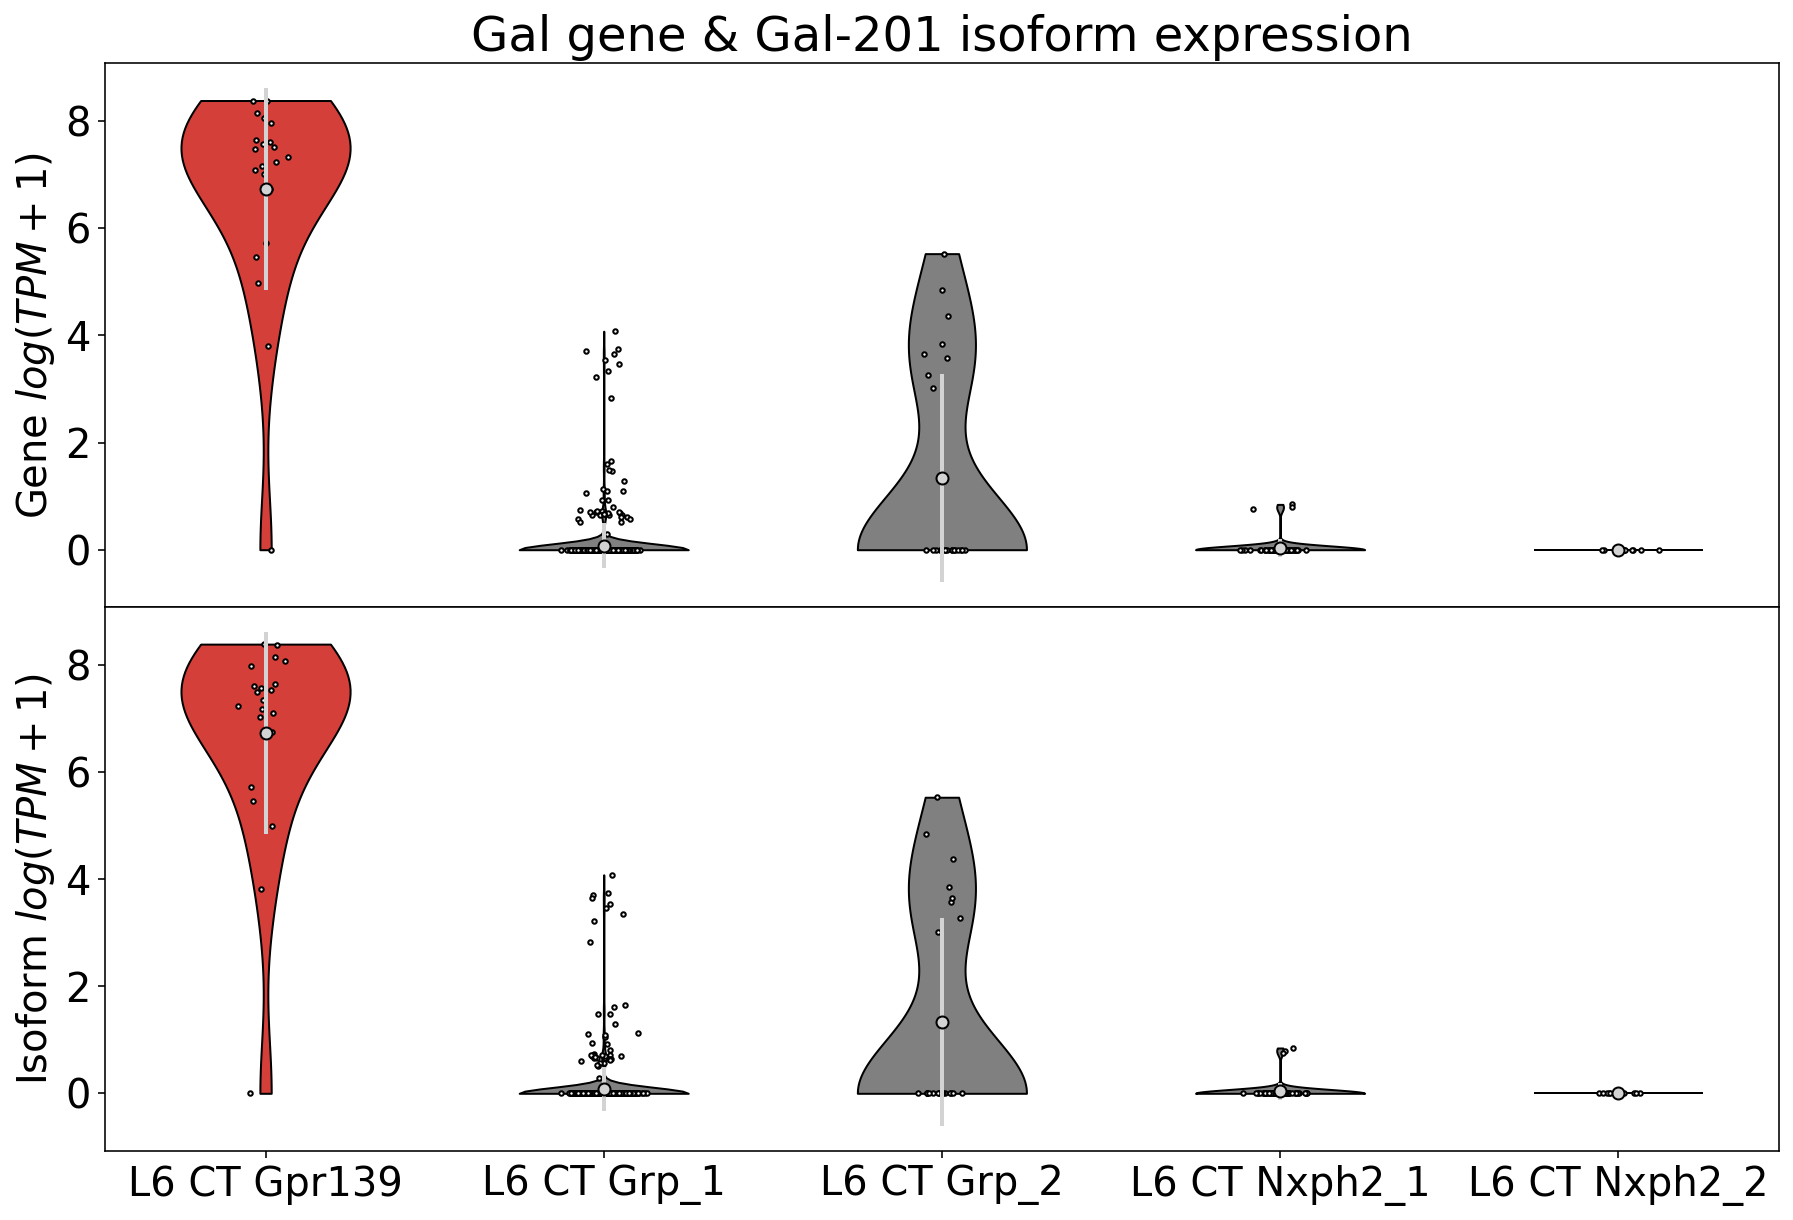

In [18]:
fig, ax = plt.subplots(figsize=(15,10), nrows=2, sharex=True)
fig.subplots_adjust(hspace=0, wspace=0)

# Declare
unique = np.unique(gene.obs.cluster_label)
unique = np.delete(unique, np.where(unique=="Low Quality"))
labels = unique
lidx = np.arange(1, len(labels)+1)  # the label locations
midx = np.where(unique==specific_cluster)[0][0]

## Plot
# Gene
x = []
for c in unique:
    x.append(np.asarray(gene[gene.obs.cluster_label==c][:,gene.var.gene_name==specific_gene].layers["log1p"].todense()).reshape(-1).tolist())
violinplot(x, ax[0], selected=midx)

# Isoform
x = []
for c in unique:
    x.append(np.asarray(isoform[isoform.obs.cluster_label==c][:,isoform.var.transcript_name==specific_isoform].layers["log1p"].todense()).reshape(-1).tolist())
violinplot(x, ax[1], selected=midx, xticks=lidx, xticklabels=labels)


## Style
ax[0].set(**{
    "title":"{} gene & {} isoform expression".format(specific_gene.split("_")[0], specific_isoform.split("_")[0]),
    "ylabel":"Gene $log(TPM + 1)$"
})
ymin, ymax = ax[0].get_ylim()
ax[1].set(**{
    "ylabel":"Isoform $log(TPM + 1)$",
    "ylim": (ymin, ymax),
})


plt.savefig("plots/cluster_DE_isoform_only_violin_{}.png".format(specific_gene.split("_")[0]), bbox_inches='tight',dpi=300)
plt.show()

In [19]:
from sklearn.neighbors import NeighborhoodComponentsAnalysis
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from matplotlib import cm

In [20]:
num_NCA = 2
state = 42
num_PCA = 100

In [21]:
X = gene.X

tsvd = TruncatedSVD(n_components=num_PCA)
Y = tsvd.fit_transform(X)

In [22]:
# NCA
X = Y
y = gene.obs.cluster_id.values.astype(int)

nca = NeighborhoodComponentsAnalysis(n_components=num_NCA,random_state=state)
YY = nca.fit_transform(X, y)

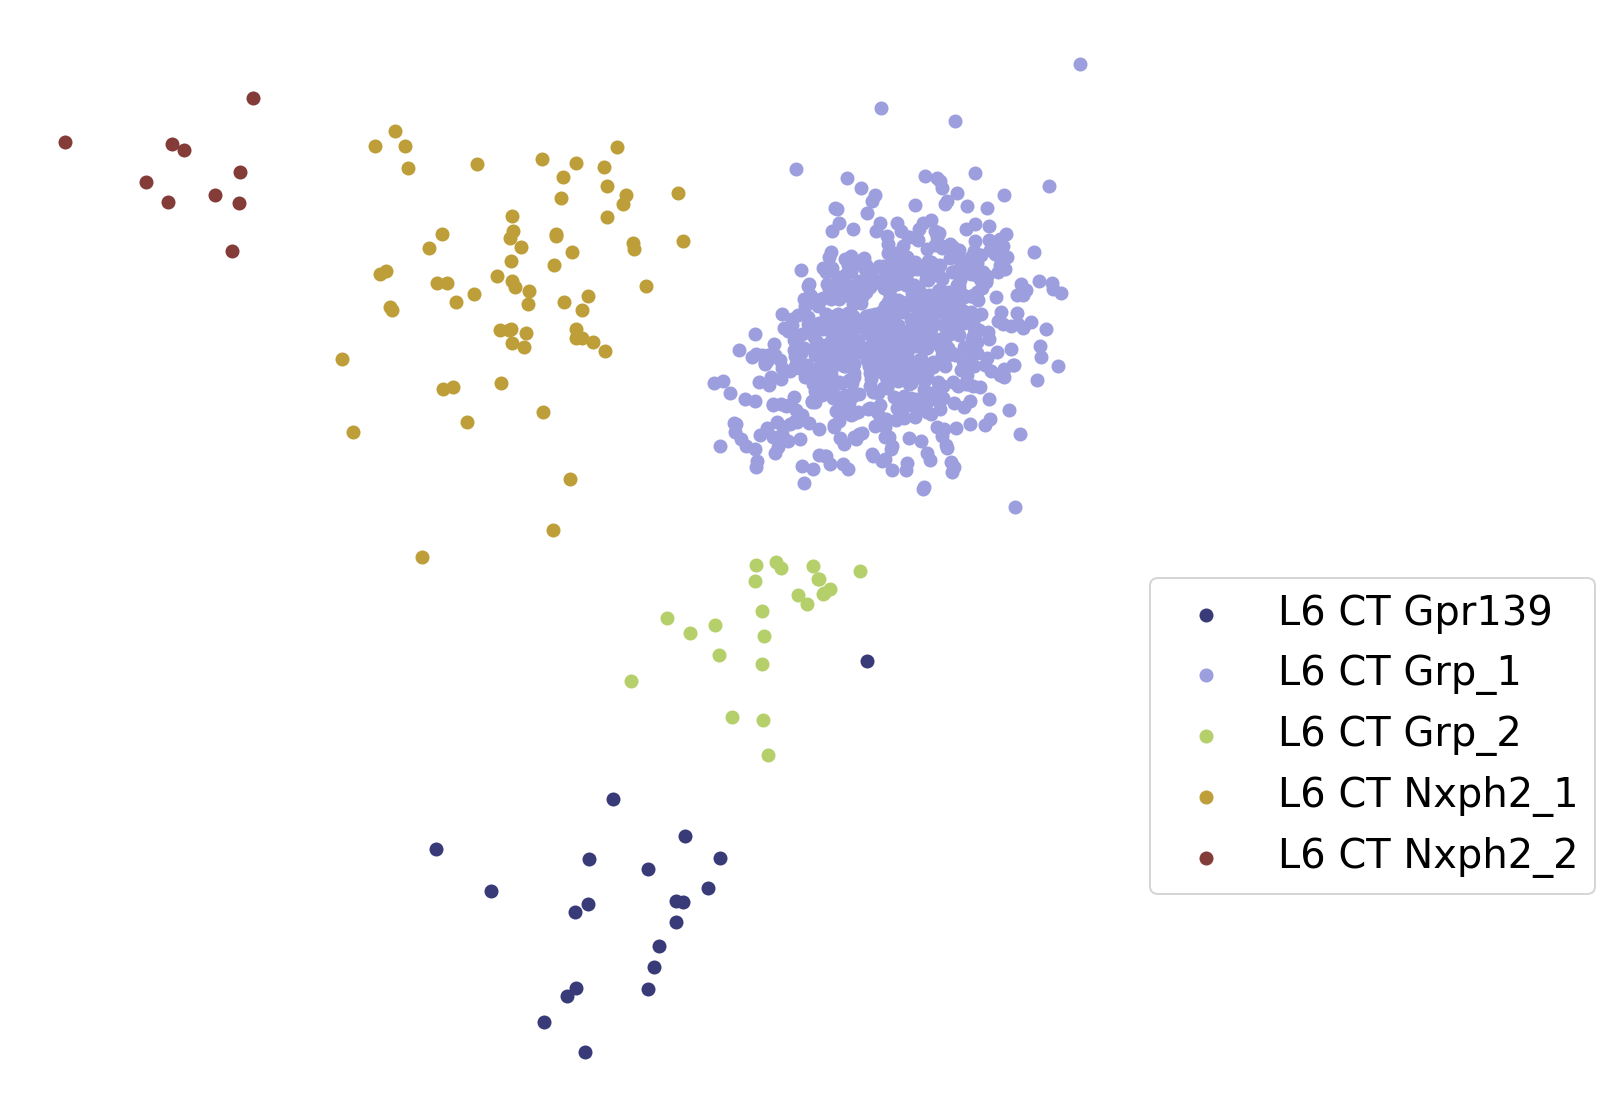

In [23]:
fig, ax = plt.subplots(figsize=(10,10))

x = YY[:,0]
y = YY[:,1]
c = cm.get_cmap("tab20b")
assignments = gene.obs.cluster_label.values
unique = np.unique(assignments)

for uidx, u in enumerate(unique):
    mask = assignments==u
    xx = x[mask]
    yy = y[mask]
    ax.scatter(xx, yy, color=c(uidx*3), cmap="tab20b", label=u)


ax.legend(bbox_to_anchor=(1, 0.5))

ax.set_axis_off()
plt.show()

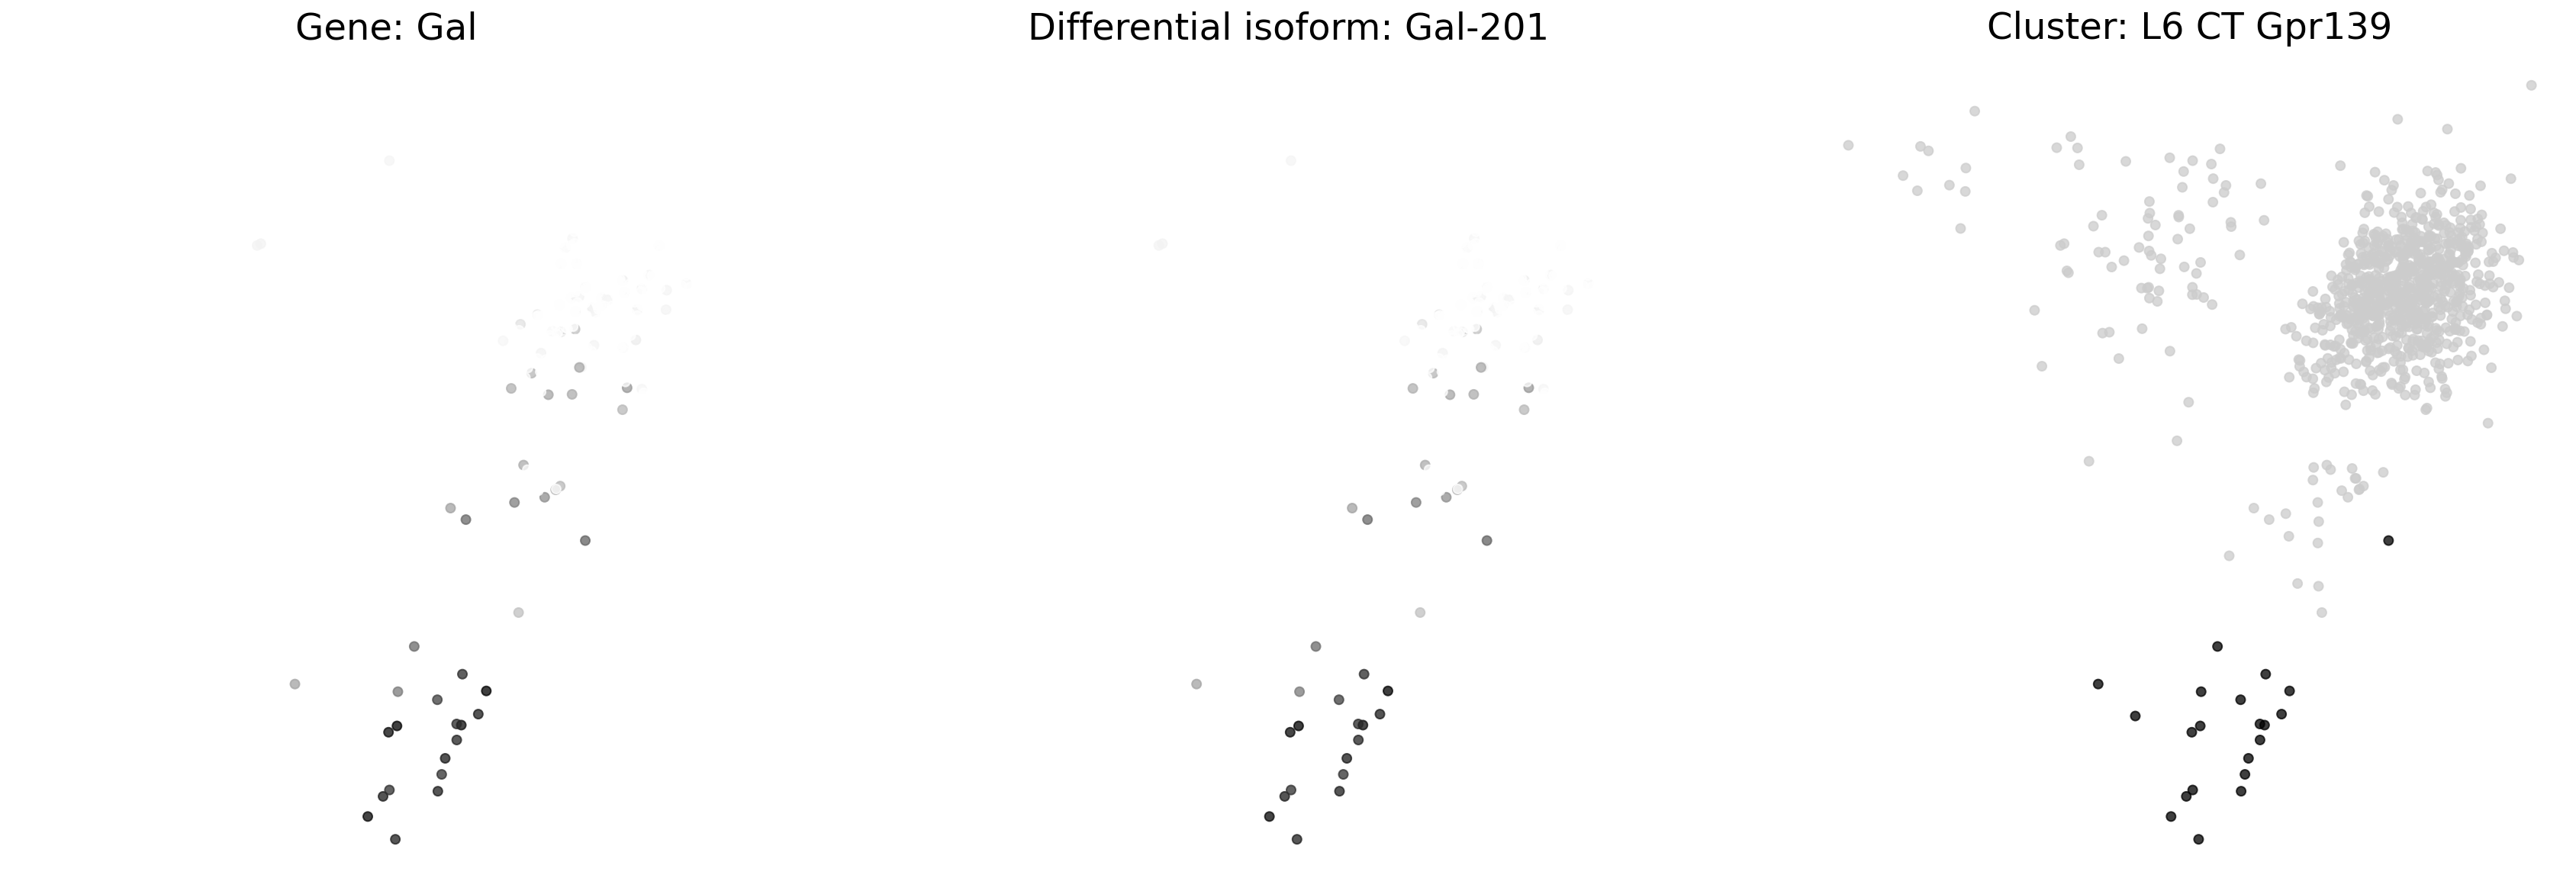

In [24]:
complement_color = (0.8, 0.8, 0.8, 1.0)

fig, ax = plt.subplots(figsize=(30,10), ncols=3)

x = YY[:,0]
y = YY[:,1]
c = np.asarray(gene[:, gene.var.gene_name==specific_gene].layers["log1p"].todense()).reshape(-1)
cmap="Greys"
alpha = 0.75
ax[0].set_title("Gene: {}".format(specific_gene.split("_")[0]))

ax[0].scatter(x, y, c=c, cmap=cmap, alpha=alpha)
ax[0].set_axis_off()


x = YY[:,0]
y = YY[:,1]
c = np.asarray(isoform[:, isoform.var.transcript_name==specific_isoform].layers["log1p"].todense()).reshape(-1)
cmap="Greys"
alpha = 0.75
ax[1].set_title("Differential isoform: {}".format(specific_isoform.split("_")[0]))

ax[1].scatter(x, y, c=c, cmap=cmap, alpha=alpha)
ax[1].set_axis_off()

x = YY[:,0]
y = YY[:,1]

c = gene.obs["cluster_id"].values.astype(int)
c = gene.obs["cluster_label"]==specific_cluster

alpha=0.75
cmap="nipy_spectral_r"

ax[2].scatter(x, y, c=c, cmap=cmap, alpha=alpha)

ax[2].set_axis_off()
ax[2].set_title("Cluster: {}".format(specific_cluster))
plt.savefig("plots/cluster_DE_isoform_only_nca_{}.png".format(specific_gene.split("_")[0]), bbox_inches='tight',dpi=300)
plt.show()

In [25]:
identified_isoforms = markers_isoform["name"].explode().astype(str)
identified_isoforms = identified_isoforms[identified_isoforms!="nan"]

In [26]:
identified_genes = identified_isoforms.apply(lambda x: x.split("-")[0:-1][0])

In [27]:
print("{} isoforms from {} genes identified.".format(identified_isoforms.shape[0], identified_genes.nunique()))

551 isoforms from 436 genes identified.


In [28]:
markers_isoform.to_csv("tables/cluster_DE_isoform_only.csv")